In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

## Load Dataset

In [2]:
from sklearn.datasets import load_digits

digits = load_digits()

In [3]:
X = digits["data"]

print(X.shape)
X

(1797, 64)


array([[  0.,   0.,   5., ...,   0.,   0.,   0.],
       [  0.,   0.,   0., ...,  10.,   0.,   0.],
       [  0.,   0.,   0., ...,  16.,   9.,   0.],
       ..., 
       [  0.,   0.,   1., ...,   6.,   0.,   0.],
       [  0.,   0.,   2., ...,  12.,   0.,   0.],
       [  0.,   0.,  10., ...,  12.,   1.,   0.]])

### Visualize

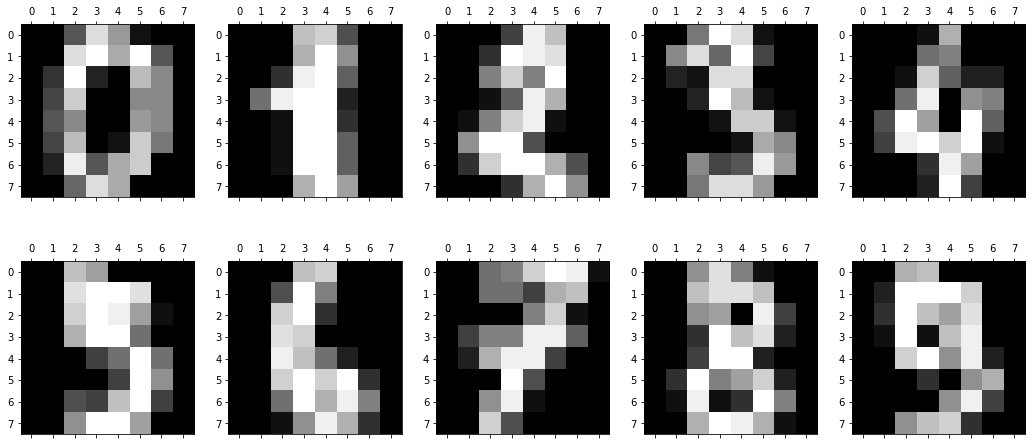

In [4]:
%matplotlib inline
import matplotlib.pyplot as plt

plt.gray()

figure, axes = plt.subplots(nrows=2, ncols=5)
figure.set_size_inches(18, 8)

axes[0][0].matshow(X[0].reshape(8, 8))
axes[0][1].matshow(X[1].reshape(8, 8))
axes[0][2].matshow(X[2].reshape(8, 8))
axes[0][3].matshow(X[3].reshape(8, 8))
axes[0][4].matshow(X[4].reshape(8, 8))
axes[1][0].matshow(X[5].reshape(8, 8))
axes[1][1].matshow(X[6].reshape(8, 8))
axes[1][2].matshow(X[7].reshape(8, 8))
axes[1][3].matshow(X[8].reshape(8, 8))
axes[1][4].matshow(X[9].reshape(8, 8))

In [5]:
y = digits["target"]

print(y.shape)
y

(1797,)


array([0, 1, 2, ..., 8, 9, 8])

## Preprocessing

In [6]:
X_mean = X.mean()

X = X - X_mean

X.mean(), X.min(), X.max()

(8.995463126623417e-17, -4.8841645798553142, 11.115835420144686)

In [7]:
from keras.utils import to_categorical

y_hot = to_categorical(y)

print(y.shape, y_hot.shape)

Using TensorFlow backend.
/Users/shaynekang/anaconda3/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)


(1797,) (1797, 10)


## Define Activation

### Sigmoid

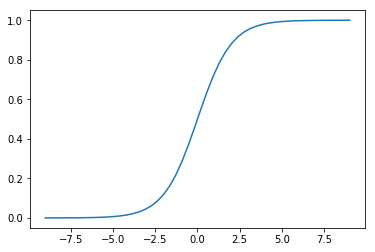

In [8]:
def sigmoid(n):
    return 1 / (1 + np.exp(-n))

xx = np.linspace(start=-9, stop=+9)
yy = sigmoid(xx)

plt.plot(xx, yy)

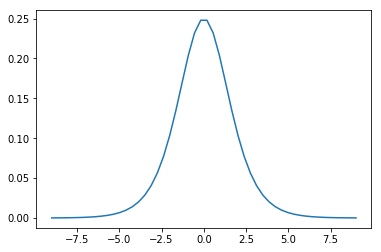

In [9]:
def sigmoid_derivative(n):
    return sigmoid(n) * (1 - sigmoid(n))

xx = np.linspace(start=-9, stop=+9)
yy = sigmoid_derivative(xx)

plt.plot(xx, yy)

## Build a Model

In [10]:
from time import time

def train(X, y, num_epoch, learning_rate, update_method):
    errors = []

    start = time()

    w1 = np.random.uniform(low=-np.sqrt(6 / (64+100)),
                           high=+np.sqrt(6 / (64+100)),
                           size=(64, 100))

    w2 = np.random.uniform(low=-np.sqrt(6 / (100+10)),
                           high=+np.sqrt(6 / (100+10)),
                           size=(100, 10))

    for epoch in range(num_epoch):
        # Forward Propagation
        z1 = X.dot(w1)
        a1 = sigmoid(z1)
        z2 = a1.dot(w2)
        a2 = sigmoid(z2)

        y_predict = np.argmax(a2, axis=1)
        error = (y_predict != y).mean()

        if epoch % (num_epoch // 10) == 0:
            print("{0:3} error = {1:.5f}".format(epoch, error))

        errors.append({
            'epoch': epoch,
            'elapsed': time() - start,
            'error': error,
        })

        # Backpropagation
        d2 = (a2 - y_hot)
        d1 = d2.dot(w2.T) * sigmoid_derivative(z1)

        # Weight gradients
        dw2 = a1.T.dot(d2)
        dw1 = X.T.dot(d1)

        w1, w2 = update_method(epoch, learning_rate, w1, w2, dw1, dw2)

    print("----" * 10)
    print("{0:3} error = {1:.5f}".format(epoch, error))
    
    errors = pd.DataFrame(errors)
    errors = errors[["epoch", "elapsed", "error"]]

    return errors

### Stochastic Gradient Descent

In [11]:
def update_sgd(epoch, learning_rate, w1, w2, dw1, dw2):
    w2 = w2 - learning_rate * dw2
    w1 = w1 - learning_rate * dw1
    
    return w1, w2

num_epoch = 100
learning_rate = 0.0001

errors_sgd = train(X, y, num_epoch, learning_rate, update_method=update_sgd)

errors_sgd.head(10)

  0 error = 0.93100
 10 error = 0.17251
 20 error = 0.09961
 30 error = 0.07290
 40 error = 0.05787
 50 error = 0.04786
 60 error = 0.03951
 70 error = 0.03506
 80 error = 0.03283
 90 error = 0.03172
----------------------------------------
 99 error = 0.02894


,epoch,elapsed,error
0,0,0.012154,0.930996
1,1,0.035699,0.882582
2,2,0.055513,0.763495
3,3,0.071872,0.633278
4,4,0.088861,0.490818
5,5,0.103035,0.374513
6,6,0.121025,0.308848
7,7,0.137180,0.259878
8,8,0.153908,0.214246
9,9,0.172161,0.192543


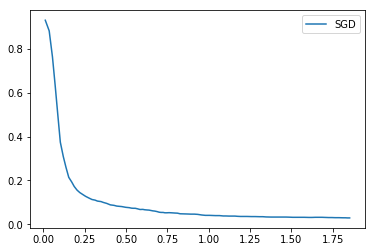

In [12]:
plt.plot(errors_sgd['elapsed'],
         errors_sgd['error'],
         label="SGD")

plt.legend()

### Momentum

In [13]:
mu = 0.9

cache_dw1, cache_dw2 = 0, 0

def update_momentum(epoch, learning_rate, w1, w2, dw1, dw2):
    global cache_dw1, cache_dw2

    cache_dw2 = mu * cache_dw2 - learning_rate * dw2
    w2 = w2 + cache_dw2

    cache_dw1 = mu * cache_dw1 - learning_rate * dw1
    w1 = w1 + cache_dw1
    
    return w1, w2

num_epoch = 100
learning_rate = 0.0001

errors_momentum = train(X, y, num_epoch, learning_rate, update_method=update_momentum)
errors_momentum.head(10)

  0 error = 0.91263
 10 error = 0.29716
 20 error = 0.09516
 30 error = 0.05175
 40 error = 0.02782
 50 error = 0.02115
 60 error = 0.01336
 70 error = 0.01002
 80 error = 0.00835
 90 error = 0.00779
----------------------------------------
 99 error = 0.00723


,epoch,elapsed,error
0,0,0.006728,0.912632
1,1,0.020245,0.892042
2,2,0.032068,0.878687
3,3,0.044173,0.813578
4,4,0.056669,0.760156
5,5,0.068350,0.671119
6,6,0.082734,0.591541
7,7,0.096931,0.459655
8,8,0.114192,0.355036
9,9,0.128628,0.283806


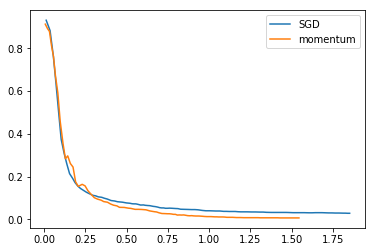

In [14]:
plt.plot(errors_sgd['elapsed'],
         errors_sgd['error'],
         label="SGD")

plt.plot(errors_momentum['elapsed'],
         errors_momentum['error'],
         label="momentum")

plt.legend()

### Nesterov Momentum

In [15]:
mu = 0.9

cache_dw1, cache_dw2 = 0, 0

def update_nesterov(epoch, learning_rate, w1, w2, dw1, dw2):
    global cache_dw1, cache_dw2

    dw2_prev = cache_dw2
    cache_dw2 = mu * cache_dw2 - learning_rate * dw2
    w2 = w2 + (-mu * dw2_prev) + (1 + mu) * cache_dw2

    dw1_prev = cache_dw1
    cache_dw1 = mu * cache_dw1 - learning_rate * dw1
    w1 = w1 + (-mu * dw1_prev) + (1 + mu) * cache_dw1

    return w1, w2

num_epoch = 100
learning_rate = 0.0001

errors_nesterov = train(X, y, num_epoch, learning_rate, update_method=update_nesterov)
errors_nesterov.head(10)

  0 error = 0.93489
 10 error = 0.10963
 20 error = 0.04396
 30 error = 0.02337
 40 error = 0.01391
 50 error = 0.00890
 60 error = 0.00723
 70 error = 0.00501
 80 error = 0.00501
 90 error = 0.00501
----------------------------------------
 99 error = 0.00390


,epoch,elapsed,error
0,0,0.005905,0.934891
1,1,0.027357,0.805231
2,2,0.039572,0.738453
3,3,0.051968,0.707290
4,4,0.063571,0.625487
5,5,0.076013,0.351141
6,6,0.088301,0.297718
7,7,0.100065,0.183639
8,8,0.111459,0.179744
9,9,0.124095,0.147468


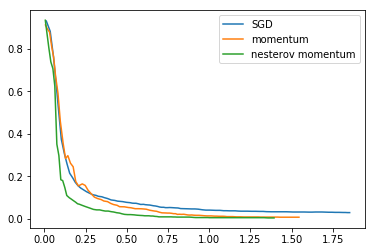

In [16]:
%matplotlib inline
import matplotlib.pyplot as plt

errors_sgd = pd.DataFrame(errors_sgd)
errors_momentum = pd.DataFrame(errors_momentum)
errors_nesterov = pd.DataFrame(errors_nesterov)

plt.plot(errors_sgd['elapsed'],
         errors_sgd['error'],
         label="SGD")

plt.plot(errors_momentum['elapsed'],
         errors_momentum['error'],
         label="momentum")

plt.plot(errors_nesterov['elapsed'],
         errors_nesterov['error'],
         label="nesterov momentum")

plt.legend()

### AdaGrad

In [17]:
eps = 0.0000001
cache_dw1, cache_dw2 = 0, 0

def update_adagrad(epoch, learning_rate, w1, w2, dw1, dw2):
    global cache_dw1, cache_dw2

    cache_dw2 = cache_dw2 + dw2 ** 2
    w2 = w2 - learning_rate * dw2 / (np.sqrt(cache_dw2) + eps)

    cache_dw1 = cache_dw1 + dw1 ** 2
    w1 = w1 - learning_rate * dw1 / (np.sqrt(cache_dw1) + eps)

    return w1, w2

num_epoch = 100
learning_rate = 0.01

errors_adagrad = train(X, y, num_epoch, learning_rate, update_method=update_adagrad)
errors_adagrad.head(10)

  0 error = 0.91375
 10 error = 0.17084
 20 error = 0.10184
 30 error = 0.07902
 40 error = 0.06733
 50 error = 0.05676
 60 error = 0.05120
 70 error = 0.04341
 80 error = 0.03840
 90 error = 0.03673
----------------------------------------
 99 error = 0.03506


,epoch,elapsed,error
0,0,0.007458,0.913745
1,1,0.031228,0.874235
2,2,0.043316,0.685587
3,3,0.055876,0.510295
4,4,0.073702,0.396216
5,5,0.092990,0.327212
6,6,0.107155,0.275459
7,7,0.124577,0.234836
8,8,0.137666,0.204786
9,9,0.149722,0.189761


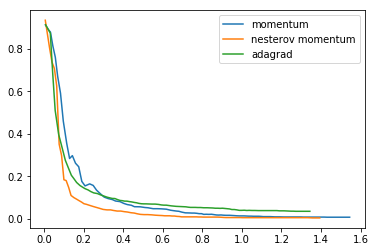

In [18]:
# plt.plot(errors_sgd['elapsed'],
#          errors_sgd['error'],
#          label="SGD")

plt.plot(errors_momentum['elapsed'],
         errors_momentum['error'],
         label="momentum")

plt.plot(errors_nesterov['elapsed'],
         errors_nesterov['error'],
         label="nesterov momentum")

plt.plot(errors_adagrad['elapsed'],
         errors_adagrad['error'],
         label="adagrad")

plt.legend()

### RMSProp

In [19]:
eps = 0.0000001
decay = 0.995
learning_rate = 0.003

cache_dw1, cache_dw2 = 0, 0


def update_rmsprop(epoch, learning_rate, w1, w2, dw1, dw2):
    global cache_dw1, cache_dw2

    cache_dw2 = decay * cache_dw2 + (1 - decay) * dw2 ** 2
    w2 = w2 - learning_rate * dw2 / np.sqrt(cache_dw2 + eps)

    cache_dw1 = decay * cache_dw1 + (1 - decay) * dw1 ** 2
    w1 = w1 - learning_rate * dw1 / np.sqrt(cache_dw1 + eps)

    return w1, w2

num_epoch = 100
learning_rate = 0.003

errors_rmsprop = train(X, y, num_epoch, learning_rate, update_method=update_rmsprop)
errors_rmsprop.head(10)

  0 error = 0.86923
 10 error = 0.11853
 20 error = 0.05064
 30 error = 0.03339
 40 error = 0.02838
 50 error = 0.02170
 60 error = 0.01725
 70 error = 0.01503
 80 error = 0.01224
 90 error = 0.01224
----------------------------------------
 99 error = 0.01057


,epoch,elapsed,error
0,0,0.011225,0.869226
1,1,0.033905,0.769616
2,2,0.047397,0.471341
3,3,0.060324,0.273790
4,4,0.073042,0.271564
5,5,0.085317,0.161380
6,6,0.097959,0.174736
7,7,0.110010,0.112410
8,8,0.122134,0.135225
9,9,0.136116,0.099610


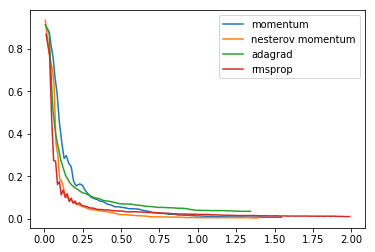

In [20]:
# plt.plot(errors_sgd['elapsed'],
#          errors_sgd['error'],
#          label="SGD")

plt.plot(errors_momentum['elapsed'],
         errors_momentum['error'],
         label="momentum")

plt.plot(errors_nesterov['elapsed'],
         errors_nesterov['error'],
         label="nesterov momentum")

plt.plot(errors_adagrad['elapsed'],
         errors_adagrad['error'],
         label="adagrad")

plt.plot(errors_rmsprop['elapsed'],
         errors_rmsprop['error'],
         label="rmsprop")

plt.legend()

### Adam

In [21]:
beta1 = 0.9
beta2 = 0.99
eps = 0.0000001

dw1m, dw2m = 0, 0
dw1v, dw2v = 0, 0

def update_adam(epoch, learning_rate, w1, w2, dw1, dw2):
    global dw1m, dw2m
    global dw1v, dw2v
    
    dw2m = beta1 * dw2m + (1 - beta1) * dw2
    dw2v = beta2 * dw2v + (1 - beta2) * (dw2 ** 2)
    dw2mb = dw2m / (1 - beta1 ** (1 + epoch))
    dw2vb = dw2v / (1 - beta2 ** (1 + epoch))

    w2 = w2 - learning_rate * dw2mb / np.sqrt(dw2vb + eps)

    dw1m = beta1 * dw1m + (1 - beta1) * dw1
    dw1v = beta2 * dw1v + (1 - beta2) * (dw1 ** 2)
    dw1mb = dw1m / (1 - beta1 ** (1 + epoch))
    dw1vb = dw1v / (1 - beta2 ** (1 + epoch))

    w1 = w1 - learning_rate * dw1mb / np.sqrt(dw1vb + eps)

    return w1, w2

num_epoch = 100
learning_rate = 0.01

errors_adam = train(X, y, num_epoch, learning_rate, update_method=update_adam)
errors_adam.head(10)

  0 error = 0.89371
 10 error = 0.46021
 20 error = 0.10351
 30 error = 0.06956
 40 error = 0.04619
 50 error = 0.03283
 60 error = 0.02504
 70 error = 0.01669
 80 error = 0.01224
 90 error = 0.01057
----------------------------------------
 99 error = 0.00946


,epoch,elapsed,error
0,0,0.012835,0.893712
1,1,0.038638,0.832499
2,2,0.056870,0.721758
3,3,0.079905,0.569282
4,4,0.101571,0.419032
5,5,0.118086,0.407902
6,6,0.141491,0.470228
7,7,0.160347,0.512521
8,8,0.180311,0.534224
9,9,0.201108,0.512521


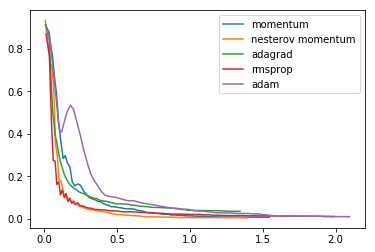

In [22]:
# plt.plot(errors_sgd['elapsed'],
#          errors_sgd['error'],
#          label="SGD")

plt.plot(errors_momentum['elapsed'],
         errors_momentum['error'],
         label="momentum")

plt.plot(errors_nesterov['elapsed'],
         errors_nesterov['error'],
         label="nesterov momentum")

plt.plot(errors_adagrad['elapsed'],
         errors_adagrad['error'],
         label="adagrad")

plt.plot(errors_rmsprop['elapsed'],
         errors_rmsprop['error'],
         label="rmsprop")

plt.plot(errors_adam['elapsed'],
         errors_adam['error'],
         label="adam")

plt.legend()